In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator
from scipy import sparse

def residual(u, v): 
    uavg = np.sqrt((u**2).sum(axis=-3).mean(axis=(-2, -1)))
    vavg = np.sqrt((v**2).sum(axis=-3).mean(axis=(-2, -1)))

    res = uavg[..., None, None]**2 * np.einsum('...jkl,...jkl->...kl', v, v)
    res += vavg[..., None, None]**2 * np.einsum('...jkl,...jkl->...kl', u, u)
    res -= 2 * vavg[..., None, None] * uavg[..., None, None] * np.einsum('...jkl,...jkl->...kl', v, u)
    res /= 2 * vavg[..., None, None] **2 * uavg[..., None, None]**2
    return res.mean(axis=(-2, -1))

class ReservoirModel(BaseEstimator):
    def __init__(self, 
                 hidden_size=2048,
                 alpha=100,
                 repeat=2):
        self.repeat = repeat
        self.hidden_size = hidden_size
        self.alpha = alpha
    
    def get_reservoir_states(self, v, tmax):
        h, w = v.shape[-2], v.shape[-1]
        v = v.reshape([v.shape[0], -1])

        v = np.matmul(v, self.readin)
        v_t = np.empty([v.shape[0], tmax, v.shape[-1]])
        v_t[:, 0] = v

        vlast = v
        for t in range(1, tmax):
            for i in range(self.repeat):
                vlast = np.tanh(
                    #vlast + np.einsum('ik,kl->il', vlast, self.evolver)
                    vlast + sparse.csr_matrix(vlast).dot(self.evolver).todense(),
                )
            v_t[:, t] = vlast

        return v_t
    
    def fit(self, X, y0):
        self.readin = np.zeros((np.prod(X.shape[1:]), self.hidden_size))
        #Read in is N_in x N_hidden
        #Each column has one non-zero element
        #Each row has on average N_hidden // N_in non-zero elements
        #Each value is drawn from a uniform distribution [-1, 1]
        column = np.arange(self.readin.shape[1])
        row = np.random.randint(self.readin.shape[0], size=self.readin.shape[1])
        self.readin[row, column] = 2. * (np.random.rand(self.readin.shape[1]) - 0.5)
        
        #Evolver is a sparse directed Erdos-Renyi random matrix 
        #non-zero elements are chosen from a uniform distribution [0, \alpha]
        #alpha is chosen to make the largest eigenvalue of A equal to \rho, the spectral radius
        num_neighbors = 3
        density = num_neighbors / self.hidden_size
        self.evolver = sparse.rand(self.hidden_size, self.hidden_size, density=density)
        E, _ = sparse.linalg.eigs(self.evolver)
        e_max = np.max(np.abs(E))
        self.evolver /= np.abs(e_max) / 0.6 #Spectral radius
        
        self.readout = Ridge(alpha=self.alpha)
        
        res_states = self.get_reservoir_states(X, y0.shape[1])
        b, t, c, h, w = y0.shape
        target = y0.reshape([b*t, c*h*w])
        inputs = res_states.reshape([b*t, -1])
        
        self.readout.fit(inputs, target)
    
    def score(self, X, y0):
        res_states = self.get_reservoir_states(X, y0.shape[1])
        b, t, c, h, w = y0.shape
        inputs = res_states.reshape([b*t, -1])
        
        preds = self.readout.predict(inputs)
        preds = preds.reshape(y0.shape)
        score = residual(preds, y0).mean()
        return score
    
    def predict(self, X, t=10):
        res_states = self.get_reservoir_states(X, t)
        b, c, h, w = X.shape
        inputs = res_states.reshape([b*t, -1])
        
        preds = self.readout.predict(inputs)
        preds = preds.reshape([b, t, -1, h, w])
        return preds

In [87]:
from dataset import *
transform = Reshape2DField()

datasets = {
    'Vel': AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform),
    'Ecd': AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform),
    'Sqh': AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform),
    'Rnt': AtlasDataset('WT', 'Runt', 'raw2D', transform=transform),
    'Moe': AtlasDataset('WT', 'moesin-GFP', 'raw2D', transform=transform),
    'Eve': AtlasDataset('WT', 'Even_Skipped', 'raw2D', drop_no_time=False, transform=transform),
    'Hst': AtlasDataset('WT', 'histone-RFP', 'raw2D', drop_no_time=False, transform=transform),
}
offsets = pd.read_csv('morphodynamic_offsets.csv')

100%|██████████| 5/5 [00:00<00:00, 337.61it/s]


# Verify morphodynamic timeline

100%|██████████| 5/5 [00:00<00:00, 444.59it/s]


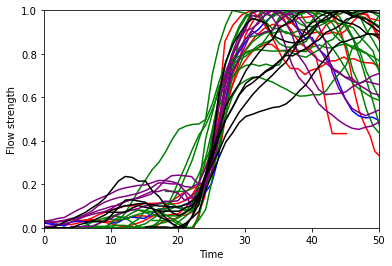

In [82]:
if not 'offsets' in globals():
    offsets = pd.read_csv('morphodynamic_offsets.csv')

offsets.loc[202001281430, 'offset'] = 3
offsets.loc[202001210044, 'offset'] = 5
offsets.loc[202001210000, 'offset'] = 5
offsets.loc[202001141730, 'offset'] = -2
offsets.loc[201406122111, 'offset'] = -4
offsets.loc[offsets.label=='moesin-GFP', 'offset'] = 3
offsets.loc[20140612184500, 'offset'] = 4
offsets.loc[20140612211100, 'offset'] = -4
offsets.loc[20140912174700, 'offset'] = -8
offsets.loc[20140916131600, 'offset'] = -14
offsets.loc[20140917212700, 'offset'] = -20

def plot_dataset_velocity(ax, dataset, legend=False, **kwargs):
    for eId in dataset.df.embryoID.unique():
        df = dataset.df[dataset.df.embryoID == eId]
        mag = np.linalg.norm(dataset.values[eId], axis=1).mean(axis=(1, 2))
        mag = (mag - mag.min()) / np.ptp(mag)
        if not eId in offsets.index:
            offsets.loc[eId, 'offset'] = 0.
            offsets.loc[eId, 'genotype'] = dataset.genotype
            offsets.loc[eId, 'label'] = dataset.path.split('/')[-1]
        if legend:
            ax.plot(df.time + offsets.loc[eId, 'offset'], mag, label=eId, **kwargs)
        else:
            ax.plot(df.time + offsets.loc[eId, 'offset'], mag, **kwargs)
    if legend:
        ax.legend()
        
ax = plt.figure().gca()
plot_dataset_velocity(ax, AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform), 
                      color='black', zorder=10)
plot_dataset_velocity(ax, AtlasDataset('WT', 'Runt', 'velocity2D', transform=transform), 
                      color='red')
plot_dataset_velocity(ax, AtlasDataset('WT', 'Even_Skipped', 'velocity2D', drop_no_time=False, transform=transform), 
                      color='blue')
plot_dataset_velocity(ax, AtlasDataset('WT', 'moesin-GFP', 'velocity2D', transform=transform), 
                      color='green')
plot_dataset_velocity(ax, AtlasDataset('WT', 'histone-RFP', 'velocity2D', drop_no_time=False, transform=transform), 
                      color='purple')

ax.set_xlim([0, 40])
ax.set(xlim=[0, 50], ylim=[0, 1], 
       xlabel='Time',
       ylabel='Flow strength')
offsets.to_csv('morphodynamic_offsets.csv')
#offsets